In [1]:
from util import read_refdata, symbol_list, \
    Z2Symbol_dict, Symbol2Z_dict
from solrs_plot import AbundPlot
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
import seaborn as sns

exp10 = lambda x: np.power(10, x)
log10 = np.log10

def func_A(M_vec, O_vec, eO_vec, flag_adopt=None):
    if flag_adopt is None:
        flag_adopt = ~ np.isnan(O_vec)
    else:
        flag_adopt = (flag_adopt) & (~np.isnan(O_vec))
    eM_vec = np.full(M_vec.shape[-1], 0.0)
    O_vec = O_vec[flag_adopt]
    eO_vec = eO_vec[flag_adopt]
    M_vec = M_vec[flag_adopt]
    eM_vec = eM_vec[flag_adopt]

    inv_err2 = 1/(np.square(eO_vec) + np.square(eM_vec))
    sum_inv_err2 = np.sum(inv_err2)
    relative_res = (M_vec - O_vec) * inv_err2
    sum_relres = np.sum(relative_res)
    A = - sum_relres / sum_inv_err2
    return A # - 0.11765639216810353

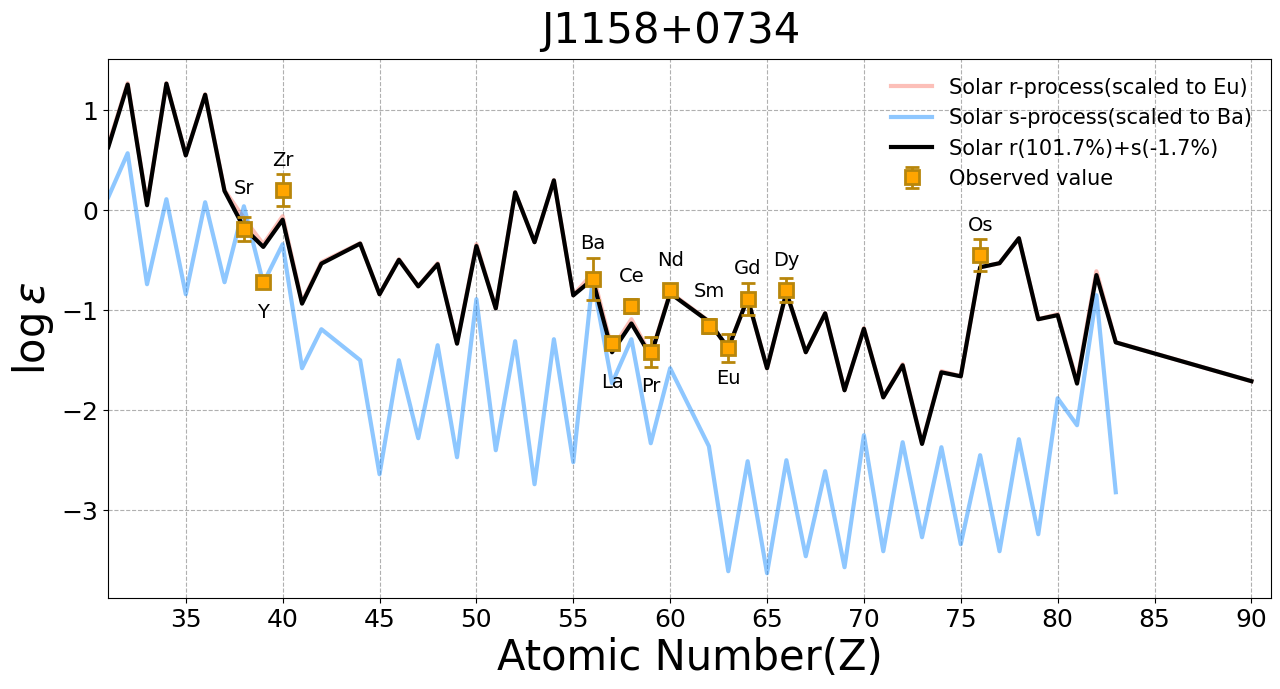

In [2]:
aplt = AbundPlot(datafile='J1158+0734.csv')
star_name = 'J1158+0734'
aplt.load_star(star_name)
fig = aplt.plot()
fig

In [3]:
nfrac_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/nst2017').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
M_mrsn = np.log10(np.array(nfrac_list))
M_mrsn = M_mrsn - M_mrsn[:, [0]] + 12# - M[:, [25]]
solmfrac, solnfrac = read_refdata('/home/jiangrz/ssd/GitHub/rproc/data/ref/sol_asplund09.dat')
solref = np.log10(solnfrac)
solref = solref - solref[0] + 12

In [4]:
nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/hw2010').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([path.stem[:4], path.stem[4:7], path.stem[7:]], dtype=np.float64)
        P_vec /= 10
        P_list.append(P_vec)
M_ccsn = np.log10(np.array(nfrac_list))
M_ccsn = M_ccsn - M_ccsn[:, [0]] + 12# - M[:, [25]]
P_ccsn = np.array(P_list)
M_ccsn_highE = M_ccsn[P_ccsn[:, 1] > 6]
P_ccsn_highE = P_ccsn[P_ccsn[:, 1] > 6]

array([[13.8,  5. , -3. ],
       [19. ,  0.9, -0.6],
       [11. , 10. , -2.4],
       ...,
       [ 9.9,  1.5, -2.2],
       [33. ,  2.4, -2.8],
       [11.4,  0.9, -1.8]])

In [14]:
O_vec = np.full(len(symbol_list), np.nan, dtype=np.float64)
eO_vec = np.full(len(symbol_list), np.nan, dtype=np.float64)
for key in aplt.star_logeps_dict:
    O_vec[Symbol2Z_dict[key]-1] = aplt.star_logeps_dict[key]
    eO_vec[Symbol2Z_dict[key]-1] = aplt.star_elogeps_dict[key]
eM_vec = np.zeros(len(symbol_list))

In [15]:
chisqr_list = []
for M_vec in M_mrsn:
    flag_adopt_mrsn = np.arange(len(O_vec)) >= 30
    flag_detect = (~np.isnan(O_vec)) & (M_vec>0)
    A = func_A(M_vec, O_vec, eO_vec, flag_adopt_mrsn)
    AmM2_vec = np.power(A + M_vec[flag_adopt_mrsn & flag_detect] - O_vec[flag_adopt_mrsn & flag_detect], 2)
    eAmM2_vec = np.power(eM_vec[flag_adopt_mrsn & flag_detect], 2) + np.power(eO_vec[flag_adopt_mrsn & flag_detect], 2)
    chisqr = np.sum(AmM2_vec/eAmM2_vec)
    chisqr_list.append(chisqr)
chisqr_arr = np.array(chisqr_list)
print(np.min(chisqr_arr))
progenitor_mrsn = M_mrsn[np.argmin(chisqr_arr), :]
A_choice = func_A(progenitor_mrsn, O_vec, eO_vec, flag_adopt_mrsn)
progenitor_mrsn += A_choice

24.052822847488088


In [16]:
chisqr_list = []
flag_adopt_ccsn = np.arange(len(O_vec)) < 30
for M_vec in M_ccsn:
    flag_detect = (~np.isnan(O_vec)) & (~np.isnan(M_vec))
    A = func_A(M_vec, O_vec, eO_vec, flag_adopt_ccsn)
    AmM2_vec = np.power(A + M_vec[flag_adopt_ccsn & flag_detect] - O_vec[flag_adopt_ccsn & flag_detect], 2)
    eAmM2_vec = np.power(eM_vec[flag_adopt_ccsn & flag_detect], 2) + np.power(eO_vec[flag_adopt_ccsn & flag_detect], 2)
    chisqr = np.sum(AmM2_vec/eAmM2_vec)
    chisqr_list.append(chisqr)
chisqr_arr = np.array(chisqr_list)
print(np.min(chisqr_arr))
progenitor_ccsn = M_ccsn[np.argmin(chisqr_arr), :]
A_ccsn = func_A(progenitor_ccsn, O_vec, eO_vec, flag_adopt_ccsn)
progenitor_ccsn += A_ccsn
print(P_ccsn[np.argmin(chisqr_arr)])

82.1515537645261
[29.5 10.  -2.4]


In [17]:
M_choice = np.full(len(symbol_list), np.nan, dtype=np.float64)
M_choice[flag_adopt_ccsn] = progenitor_ccsn[flag_adopt_ccsn]
M_choice[flag_adopt_mrsn] = progenitor_mrsn[flag_adopt_mrsn]

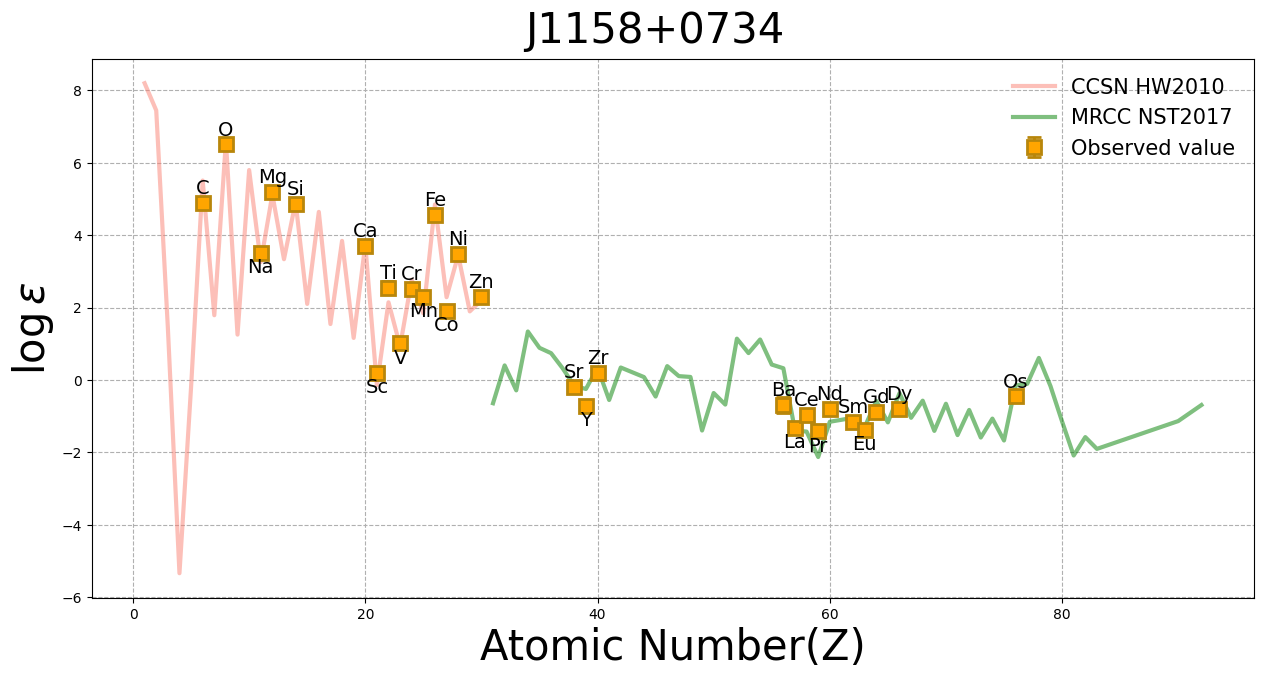

In [18]:
fig, ax = plt.subplots(
    1, 1, figsize=(15, 7), 
    # height_ratios=(2, .9), 
    dpi=100, sharex=True)
fig.subplots_adjust(hspace=.1)
Z_arr = np.array([Symbol2Z_dict[symbol] for symbol in symbol_list])
M_choice
# ax.plot(
#     Z_arr[np.isfinite(M_choice)], 
#     M_choice[np.isfinite(M_choice)], 
#     linewidth=3, c='black', alpha=.9, 
#     label="MRCC NST2017", 
#     zorder=2)
ax.plot(
    Z_arr[np.isfinite(progenitor_ccsn)&flag_adopt_ccsn], 
    progenitor_ccsn[np.isfinite(progenitor_ccsn)&flag_adopt_ccsn], 
    linewidth=3, c='salmon', alpha=.5, 
    label="CCSN HW2010", 
    zorder=2)
ax.plot(
    Z_arr[np.isfinite(progenitor_mrsn)&flag_adopt_mrsn], 
    progenitor_mrsn[np.isfinite(progenitor_mrsn)&flag_adopt_mrsn], 
    linewidth=3, c='green', alpha=.5, 
    label="MRCC NST2017", 
    zorder=2)
ec = 'darkgoldenrod'
ew = 2
ax.errorbar(
    Z_arr, O_vec, yerr=eO_vec,
    ecolor=ec, elinewidth=ew, linestyle='', capsize=5, capthick=3,
    marker='s', markersize=10, mfc='orange', mec=ec, mew=ew,
    label='Observed value', 
    alpha=1, zorder=4)
for _idx, (_x, _y) in enumerate(zip(Z_arr, O_vec)):
    if np.isnan(_y):
        continue
    dist = .4
    _t = Z2Symbol_dict[_x]
    sign_pos = +1
    if _x % 2 == 1:
        sign_pos = -1
    _y += (sign_pos * dist)
    ax.text(_x, _y, _t, ha='center', va='center', fontsize=14, zorder=5)
ax.grid(True, linestyle='--', alpha=1, zorder=1)

ax.set_xlabel("Atomic Number(Z)", size=30)
ax.set_ylabel(r'$\log\varepsilon$', size=30)
# # axes[1].set_ylabel(r'$\Delta$ log $\varepsilon$', fontdict={'size': 25})
# # axes[1].set_ylabel(r'$|\Delta\log\varepsilon|/\sigma$', fontdict={'size': 30})
ax.legend(loc='best', fontsize=15, frameon=False)
fig.suptitle(star_name, y=.95, size=30)
# if fname is not None:
#     fig.savefig(fname, **kw)
# plt.close()
plt.show();